# Team members:

- Abdelhamid Bouzid
- Tomas F. Llano Rios

In [1]:
import codecs
import string
import nltk
nltk.download('stopwords')
nltk.download('movie_reviews')
nltk.download('vader_lexicon')

import nltk.classify.util
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import movie_reviews

from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import RegexpTokenizer, sent_tokenize

from nltk.sentiment.vader import SentimentIntensityAnalyzer


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


Use Words as features

In [2]:
def word_feats(words):
    return dict([(word, True) for word in words])

Tokenization, stemming, etc.

In [3]:
english_stemmer = SnowballStemmer('porter')
english_stop_words = stopwords.words('english')+list(string.punctuation)
tokenizer = RegexpTokenizer(r'\w+')

In [4]:
import re
def tokenize(words):
    stemmed_words = []
    for w in words:
        if w not in english_stop_words:
            try:
                stemmed_words.append(w)
            except:
                continue

    return stemmed_words


# Original ETL and training process given 

Extract Negative and positive features


In [5]:
negids = movie_reviews.fileids('neg')
posids = movie_reviews.fileids('pos')
negfeats = [(word_feats(movie_reviews.words(fileids=[f])), 'neg') for f in negids]
posfeats = [(word_feats(movie_reviews.words(fileids=[f])), 'pos') for f in posids]

Split the data into train and test

In [6]:
negcutoff = int(len(negfeats)*3/4)
poscutoff = int(len(posfeats)*3/4)
trainfeats = negfeats[:negcutoff] + posfeats[:poscutoff]
testfeats = negfeats[negcutoff:] + posfeats[poscutoff:]
print('train on %d instances, test on %d instances' % (len(trainfeats), len(testfeats)))

train on 1500 instances, test on 500 instances


Classifiers 

In [7]:
classifier = NaiveBayesClassifier.train(trainfeats)
print('accuracy: %f' % nltk.classify.util.accuracy(classifier, testfeats))
classifier.show_most_informative_features()

accuracy: 0.728000
Most Informative Features
             magnificent = True              pos : neg    =     15.0 : 1.0
             outstanding = True              pos : neg    =     13.6 : 1.0
               insulting = True              neg : pos    =     13.0 : 1.0
              vulnerable = True              pos : neg    =     12.3 : 1.0
               ludicrous = True              neg : pos    =     11.8 : 1.0
                  avoids = True              pos : neg    =     11.7 : 1.0
             uninvolving = True              neg : pos    =     11.7 : 1.0
             fascination = True              pos : neg    =     10.3 : 1.0
              astounding = True              pos : neg    =     10.3 : 1.0
                 idiotic = True              neg : pos    =      9.8 : 1.0


# Experiment 1: Select subsets of data in different ways

In [8]:
import pandas as pd
words = []
freqs = []
for word, freq in nltk.FreqDist(movie_reviews.words()).items():
  words.append(word)
  freqs.append(freq)

wordFreqs = pd.DataFrame.from_dict({"words":words, "freqs":freqs})
wordFreqs.describe()

,freqs
count,39768.000000
mean,39.826494
std,821.768263
min,1.000000
25%,1.000000
50%,3.000000
75%,9.000000
max,77717.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f034df69f90>]],
      dtype=object)

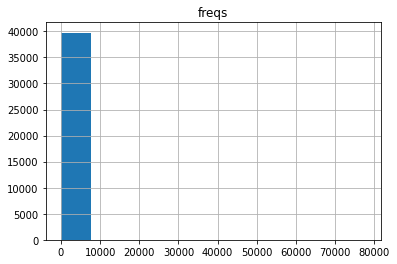

In [9]:
wordFreqs.hist()

## Stop Words (SW)

In [10]:
words_noSW = tokenize(nltk.FreqDist(movie_reviews.words()).keys())
noSWFreqs = wordFreqs[wordFreqs["words"].isin(words_noSW)]
noSWFreqs.sort_values(by=["freqs"], ascending=False)

,words,freqs
162,film,9517
21,one,5852
43,movie,5771
143,like,3690
69,even,2565
...,...,...
26318,ooooooo,1
26321,sp,1
26325,wimmin,1
26326,puked,1


In [11]:
len(noSWFreqs)

39587

## Polarity score
- score >= 0.5 is considered a positive word
- score <= -0.5 is considered a negative word
- score in the range (-0.5, 0.5) is considered a neutral word

In [12]:
sid = SentimentIntensityAnalyzer()
for word in words_noSW:
  pScore = (sid.polarity_scores(word)['compound'])
  if pScore > -0.05 and pScore < 0.05:
    noSWFreqs = noSWFreqs[noSWFreqs["words"] != word]
noSWFreqs

,words,freqs
9,party,183
20,accident,104
51,fuck,17
58,cool,208
62,bad,1395
...,...,...
39651,sentimentalized,1
39709,motivate,2
39727,douchebag,1
39729,fiesta,1


In [13]:
noSWFreqs.describe()

,freqs
count,3694.000000
mean,30.694640
std,109.814295
min,1.000000
25%,2.000000
50%,7.000000
75%,22.000000
max,3690.000000


## Filter low frequency words

In [14]:
noSWFiltered = noSWFreqs[noSWFreqs['freqs'] > noSWFreqs['freqs'].mean()].sort_values(by=['freqs'], ascending=False).reset_index(drop=True)
noSWFiltered

,words,freqs
0,like,3690
1,good,2411
2,well,1906
3,bad,1395
4,best,1333
...,...,...
725,nifty,31
726,confidence,31
727,hates,31
728,assured,31


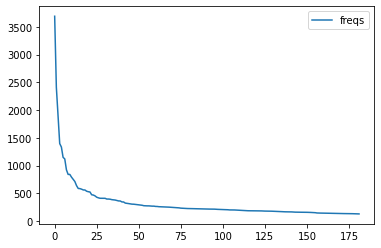

In [15]:
noSWFiltered[noSWFiltered['freqs'] > noSWFiltered['freqs'].mean()].plot()

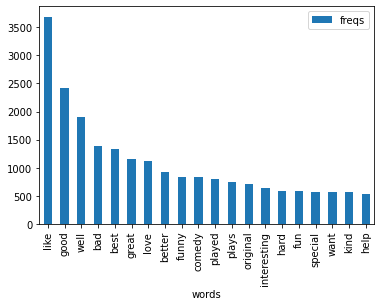

In [16]:
noSWFiltered.head(20).plot.bar(x='words', y='freqs')

# Experiment 2: Use different preprocessing methods
with and without TF-IDF, with and without stop words, with and without stemming, lemmatization, unigrams only, unigrams + bigrams, etc

## Stemming
(note we already did "without stemming" in the previous experiment)

In [17]:
def stem(word):
 return english_stemmer.stem(word)

stemmed_words = tokenize(nltk.FreqDist(movie_reviews.words()).keys())
stemmedFreqs = wordFreqs[wordFreqs["words"].isin(stemmed_words)]
stemmedFreqs.loc[:,'words'] = stemmedFreqs["words"].apply(func=stem)
stemmedFreqs[stemmedFreqs.duplicated(["words"])]


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


,words,freqs
74,gener,103
95,make,602
118,problem,396
133,go,888
162,film,9517
...,...,...
39754,countrysid,1
39758,panel,1
39761,obstruct,1
39762,obscur,1


In [18]:
stemmedFreqs[stemmedFreqs.duplicated(["words"])].groupby('words').agg({'freqs':'sum'}).sort_values(['freqs'], ascending=False)

,freqs
words,
film,9663
make,2251
charact,2022
play,2020
way,1693
...,...
butabi,1
percuss,1
perenni,1


## Without Stop Words
(note we did stop words in the previous experiment)

## With and Without Tf IDF



In [19]:
documents = []
 
for category in movie_reviews.categories():
    for fileid in movie_reviews.fileids(category):
      documents.append(movie_reviews.words(fileids=[fileid]))

In [20]:
from collections import Counter
import numpy as np

tf_list = []
wordFreqs = {}
for el in documents:
  dict1       = Counter(el)
  L           = len(el)
  tf_cur = {}
  for word,value in dict1.items():
    try:
      wordFreqs[word] += 1
    except:
       wordFreqs[word] = 1
    tf = value/L
    tf_cur[word] = tf

  tf_list.append(tf_cur)

In [21]:
N = len(documents)
index = {}
for word, freq in wordFreqs.items():
  index[word] = np.log(N/freq)

In [22]:
tf_pdf = []
for el in tf_list:
  new_dict = {}
  for word,tf in el.items():
    cur_tf_pdf = tf*index[word]
    new_dict[word] = cur_tf_pdf
  tf_pdf.append(new_dict)

In [23]:
tf_pdf[0]

{'!': 0.0037683531377345385,
 '"': 0.0029734330390717577,
 '&': 0.002939274883648644,
 "'": 0.00020133692576882777,
 '(': 0.0005251873145482984,
 ')': 0.0005197998333138555,
 ',': 7.51416946026808e-05,
 '-': 0.0006556213064463757,
 '.': 0.0,
 '/': 0.013007525480147141,
 '10': 0.02696011197596696,
 '2': 0.0022951150748127223,
 '20': 0.0035535445336335333,
 '3': 0.003017227041142109,
 '4': 0.003331141780523522,
 '7': 0.007440657836759388,
 '8': 0.00357969870681294,
 '9': 0.008176494367029833,
 ':': 0.0016232742936224277,
 '?': 0.0033294221899999635,
 'a': 3.188627689353989e-05,
 'about': 0.0007145075035071281,
 'accident': 0.0036478422125934508,
 'actors': 0.00153469690145187,
 'actually': 0.0028362512371893785,
 'after': 0.001427438998912269,
 'again': 0.0030958512272384817,
 'ago': 0.002752126176621157,
 'all': 0.0015103775217237502,
 'also': 0.0007105283152381497,
 'although': 0.0015151378564685106,
 'always': 0.0017173976990493562,
 'american': 0.0020125369536502452,
 'an': 0.0003881

# Experiment 3: Use different classifiers
Classifiers (Probabilistic vs Logistic Regression vs SVM) and parameters (use different models in Probabilistic classifiers: Bernoulli vs Multinomial)

In [50]:
length_features = 2000
all_words       = nltk.FreqDist(movie_reviews.words())
feature_vector  = list(all_words)[:length_features]

In [51]:
documents = [(movie_reviews.words(file_id),category) for file_id in movie_reviews.fileids() for category in movie_reviews.categories(file_id)]
documents[0][0]

['plot', ':', 'two', 'teen', 'couples', 'go', 'to', ...]

In [52]:
import numpy as np

def transformToarray(documents,data,labels):
  for i,doc in enumerate(documents):
    for word in doc[0]:
      if word in feature_vector:
        index = feature_vector.index(word)
        data[i,index] = 1

    
    if doc[1]=='neg':
      labels[i] = 0
    else:
      labels[i] = 1

  return data,labels

In [53]:
data   = np.zeros((len(documents),length_features))
labels = np.zeros(len(documents))

data,labels = transformToarray(documents,data,labels)

In [54]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( data, labels, test_size=0.20)

## SVM classifier 

In [60]:
from sklearn import svm
from sklearn.metrics import accuracy_score

In [56]:
clf = svm.SVC()
clf.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
test_pred = clf.predict(X_test)
test_pred

In [61]:
accuracy_score(y_test, test_pred)

0.805

## Logistic regression 

In [62]:
from sklearn.linear_model import LogisticRegression

In [63]:
clf = LogisticRegression(random_state=0).fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
test_pred = clf.predict(X_test)
test_pred

In [65]:
accuracy_score(y_test, test_pred)

0.78

## Probabilistic model 

### Bernoulli classifier

In [66]:
from sklearn.naive_bayes import BernoulliNB
clf = BernoulliNB()

In [67]:
clf.fit(X_train, y_train)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [ ]:
test_pred = clf.predict(X_test)
test_pred

In [69]:
accuracy_score(y_test, test_pred)

0.78

### Multinomial classifier 

In [70]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()

In [71]:
clf.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [ ]:
test_pred = clf.predict(X_test)
test_pred

In [73]:
accuracy_score(y_test, test_pred)

0.8075